In [1]:
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import obspy
import datetime
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# Adding pyDAS location
pyDAS_path = "/home/yinjx/DAS-utilities/build/"
import os
try:
    os.environ['LD_LIBRARY_PATH'] += ":" + pyDAS_path
except:
    os.environ['LD_LIBRARY_PATH'] = pyDAS_path
import sys
sys.path.insert(0,pyDAS_path)
sys.path.insert(0,'/home/yinjx/DAS-utilities/python')
import DASutils
import importlib
importlib.reload(DASutils)

<module 'DASutils' from '/home/ebiondi/research/packages/DAS-proc/python/DASutils.py'>

In [3]:
# load the DAS channel location (old 6250 channels and new 5000 channels)
# old generation
DAS_info_old = pd.read_csv('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Olancha_Plexus.txt', 
                            sep='\s+', header=None, engine='python')

DAS_channel_num_old = DAS_info_old.shape[0]
DAS_index_old = DAS_info_old.iloc[:, 0].astype('int')
DAS_lon_old = DAS_info_old.iloc[:, 1]
DAS_lat_old = DAS_info_old.iloc[:, 2]

# new generation
DAS_info_new = pd.read_csv('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Olancha_Plexus_100km.txt',
                            sep=',', engine='python')
DAS_info_new = DAS_info_new.dropna()
DAS_info_new = DAS_info_new[(DAS_info_new.status == 'good') & (DAS_info_new.channel < 5000)]

DAS_channel_num_new = DAS_info_new.shape[0]
DAS_index_new = DAS_info_new.iloc[:, 0].astype('int')
DAS_lon_new = DAS_info_new.iloc[:, 3]
DAS_lat_new = DAS_info_new.iloc[:, 2]
DAS_elev_new = DAS_info_new.iloc[:, 4]

In [4]:
from scipy.interpolate import griddata
# interpolation to get the elevation for old array settings
DAS_elev_old = griddata( np.array([DAS_lon_new, DAS_lat_new]).T, DAS_elev_new, np.array([DAS_lon_old, DAS_lat_old]).T, method='nearest')

In [5]:
# Write to a csv in the EventData folder for OLD array setting
DAS_info_df = pd.DataFrame({'index': DAS_index_old, 'latitude': DAS_lat_old, 'longitude': DAS_lon_old, 'elevation_m': DAS_elev_old})
DAS_info_df.to_csv('/kuafu/EventData/Olancha_old_20200626_20210227/das_info.csv', index=False)

# Write to a csv in the EventData folder for NEW array setting
DAS_info_df = pd.DataFrame({'index': DAS_index_new, 'latitude': DAS_lat_new, 'longitude': DAS_lon_new, 'elevation_m': DAS_elev_new})
DAS_info_df.to_csv('/kuafu/EventData/Olancha_new_20210313_20211013/das_info.csv', index=False)

In [6]:
# Define the path to store all the output results
output_dir = '/home/yinjx/kuafu/Olancha_Plexus_100km'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [7]:
import glob
data_dir = '/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/'

files = glob.glob(data_dir + '/*.h5')
files.sort()

# Only keep the "COMPLETE" data with size > 5G
files = [file for file in files if os.path.getsize(file)/1e9 > 5] 
file_names = [os.path.basename(file) for file in files]

print(f'Total file number: {len(files)}')
print(f'Total file number: {len(file_names)}')
print(file_names[0])
print(file_names[-1])

Total file number: 6597
Total file number: 6597
Olancha-2020-06-26 025129Z.h5
Olancha-2021-10-13T181002Z.h5


In [8]:
# Prepare a DataFrame to include the DAS files and corresponding Time information
file_UTCDateTime_tbeg = []
instrument_type_all = []

for ii, file in enumerate(file_names):
    file_UTCDateTime_tbeg.append(obspy.UTCDateTime(file[8:-3]))
    if 'T' in file:
        instrument_type_all.append('new')
    else:
        instrument_type_all.append('old')
    
    
df_files = pd.DataFrame(columns=['files_abs', 'file_name', 't_begin', 'instrument_type'])
df_files.files_abs = files
df_files.file_name = file_names
df_files.t_begin = file_UTCDateTime_tbeg
df_files.instrument_type = instrument_type_all

In [9]:
df_files

,files_abs,file_name,t_begin,instrument_type
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old
1,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 035047Z.h5,2020-06-26T03:50:47.000000Z,old
2,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 045047Z.h5,2020-06-26T04:50:47.000000Z,old
3,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 055047Z.h5,2020-06-26T05:50:47.000000Z,old
4,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 065047Z.h5,2020-06-26T06:50:47.000000Z,old
...,...,...,...,...
6592,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T141002Z.h5,2021-10-13T14:10:02.000000Z,new
6593,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T151002Z.h5,2021-10-13T15:10:02.000000Z,new
6594,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T161002Z.h5,2021-10-13T16:10:02.000000Z,new
6595,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T171002Z.h5,2021-10-13T17:10:02.000000Z,new


In [10]:
df_files.to_csv(output_dir + '/data_file_list.csv')

In [11]:
# Old data
df_files_old = df_files[df_files.instrument_type == 'old']
df_files_old

# New data
df_files_new = df_files[df_files.instrument_type == 'new']
df_files_new

,files_abs,file_name,t_begin,instrument_type
2684,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T014855Z.h5,2021-03-13T01:48:55.000000Z,new
2685,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T024855Z.h5,2021-03-13T02:48:55.000000Z,new
2686,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T034855Z.h5,2021-03-13T03:48:55.000000Z,new
2687,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T044855Z.h5,2021-03-13T04:48:55.000000Z,new
2688,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T054855Z.h5,2021-03-13T05:48:55.000000Z,new
...,...,...,...,...
6592,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T141002Z.h5,2021-10-13T14:10:02.000000Z,new
6593,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T151002Z.h5,2021-10-13T15:10:02.000000Z,new
6594,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T161002Z.h5,2021-10-13T16:10:02.000000Z,new
6595,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T171002Z.h5,2021-10-13T17:10:02.000000Z,new


In [12]:
df_files_new

,files_abs,file_name,t_begin,instrument_type
2684,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T014855Z.h5,2021-03-13T01:48:55.000000Z,new
2685,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T024855Z.h5,2021-03-13T02:48:55.000000Z,new
2686,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T034855Z.h5,2021-03-13T03:48:55.000000Z,new
2687,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T044855Z.h5,2021-03-13T04:48:55.000000Z,new
2688,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-03-13T054855Z.h5,2021-03-13T05:48:55.000000Z,new
...,...,...,...,...
6592,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T141002Z.h5,2021-10-13T14:10:02.000000Z,new
6593,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T151002Z.h5,2021-10-13T15:10:02.000000Z,new
6594,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T161002Z.h5,2021-10-13T16:10:02.000000Z,new
6595,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T171002Z.h5,2021-10-13T17:10:02.000000Z,new


In [13]:
# convert the phase shift to strain given a gauge length
def phase_to_strain(phase, L=16):
    strain = phase * 1550.12 * 1e-9 / (0.78 * 2 * np.pi * 1.46 * L)
    return strain

In [14]:
# Define some reusable functions
def plot_data(DAS_dataS, title='Data'):
    # visualize the data every 5 mins
    fig, ax1 = plt.subplots(figsize=(16,8))
    pclip=98
    clipVal = np.percentile(np.absolute(DAS_dataS), pclip)
    # Vx
    ax1.imshow(DAS_dataS.T, 
               extent=[0, DAS_dataS.shape[0]-1, tAx_secS[-1], tAx_secS[0]],
               aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))
    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()
    ax1.set_title(title)
    
    return fig

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 34.5 38.5 -lon -120 -116 -t0 2020/6/26,00:00:00 2021/10/13,18:00:00 -f Olancha_das_catalog_M2_M8.txt

EVENT -mag 1.0 8.0 -lat 34.5 38.5 -lon -120 -116 -t0 2020/6/26,00:00:00 2021/10/13,18:00:00 -f Olancha_das_catalog_M1_M8.txt
```

In [15]:
catalog_file = '/home/yinjx/notebooks/strain_scaling/Olancha_das_catalog_M1_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog = catalog.dropna()

In [16]:
catalog[7] = catalog[7].astype(float)
catalog_select = catalog[(catalog[7] >= 1) & (catalog[6] > 1)] # choose the event with magnitude > 3.5
#catalog_select = catalog[(catalog[7] >= 3) & (catalog[7] <= 3.5) & (catalog[6] > 1)] # choose the event with magnitude <= 3.5

In [17]:
eq_num = catalog_select.shape[0]
eq_id = np.array(catalog_select[0])
eq_time = np.array(catalog_select[3])
eq_lat = np.array(catalog_select[4])
eq_lon = np.array(catalog_select[5])
eq_dep = np.array(catalog_select[6])
eq_mag = np.array(catalog_select[7])
eq_mag_type = 'm' + np.array(catalog_select[8])

print(f'Total number of events: {eq_num}')

Total number of events: 5883


In [18]:
# Convert the event time to obspy UTCDateTime and also find the corresponding DAS file name
import datetime
import obspy

# event time in obspy.UTCDateTime
eq_time_UTCDateTime = [obspy.UTCDateTime(temp) for temp in eq_time]
eq_time_str = [obspy.UTCDateTime(temp).isoformat() + '+00:00' for temp in eq_time]
# corresponding das file name
eq_das_files = [datetime.datetime.strptime(temp[:-4],'%Y/%m/%d,%H:%M:%S').strftime('%Y%m%d%H.segy') for temp in eq_time]
# corresponding das data initial time in UTCDateTime form
eq_das_t0 = [obspy.UTCDateTime(temp[0:-5]) for temp in eq_das_files]

In [19]:
# Write to a catalog.csv in the EventData folder
event_info_df = pd.DataFrame({'event_id': eq_id, 'event_time': eq_time_str,
'latitude': eq_lat, 'longitude': eq_lon, 'depth_km': eq_dep, 'magnitude': eq_mag, 'magnitude_type': eq_mag_type, 'source': 'scsn'})


In [20]:
i_data_found = 0
data_found_df = pd.DataFrame()
eq_index = []

for i_eq, eq_time in enumerate(eq_time_UTCDateTime):
    try:
        ii = (df_files.t_begin < eq_time) & (df_files.t_begin > eq_time - 3600)
        event_found = df_files[ii].copy()
        if len(event_found) > 0:
            eq_index.append(i_eq)
            event_found['eq_id'] = eq_id[i_eq]
            event_found['eq_time'] = eq_time
            data_found_df = pd.concat([data_found_df, event_found])
            i_data_found += 1
            print('=' * 10 + str(i_data_found) + '=' * 10)
            print(f'Event time: {eq_time}')
            print(f'Data begin time: {event_found.t_begin}')
    except:
        continue

==========1==========
Event time: 2020-06-26T02:54:04.160000Z
Data begin time: 0    2020-06-26T02:51:29.000000Z
Name: t_begin, dtype: object
==========2==========
Event time: 2020-06-26T03:28:28.370000Z
Data begin time: 0    2020-06-26T02:51:29.000000Z
Name: t_begin, dtype: object
==========3==========
Event time: 2020-06-26T03:40:24.580000Z
Data begin time: 0    2020-06-26T02:51:29.000000Z
Name: t_begin, dtype: object
==========4==========
Event time: 2020-06-26T03:41:39.430000Z
Data begin time: 0    2020-06-26T02:51:29.000000Z
Name: t_begin, dtype: object
==========5==========
Event time: 2020-06-26T03:53:02.630000Z
Data begin time: 1    2020-06-26T03:50:47.000000Z
Name: t_begin, dtype: object
==========6==========
Event time: 2020-06-26T04:04:21.500000Z
Data begin time: 1    2020-06-26T03:50:47.000000Z
Name: t_begin, dtype: object
==========7==========
Event time: 2020-06-26T04:24:07.640000Z
Data begin time: 1    2020-06-26T03:50:47.000000Z
Name: t_begin, dtype: object
==========8==

In [21]:
event_info_df = event_info_df[event_info_df.event_id.isin(data_found_df.eq_id)]

In [22]:
event_info_df.to_csv('/kuafu/EventData/Olancha_old_20200626_20210227/catalog.csv', index=False)
event_info_df.to_csv('/kuafu/EventData/Olancha_new_20210313_20211013/catalog.csv', index=False)

### Show a simple map for the DAS array and events

In [23]:
catalog_select0 = catalog_select[catalog_select[0].isin(data_found_df.eq_id)]
catalog_select0

eq_num = catalog_select0.shape[0]
eq_id = np.array(catalog_select0[0])
eq_time = np.array(catalog_select0[3])
eq_lat = np.array(catalog_select0[4])
eq_lon = np.array(catalog_select0[5])
eq_dep = np.array(catalog_select0[6])
eq_mag = np.array(catalog_select0[7])

print(f'Total number of events: {eq_num}')
catalog_select0.to_csv(output_dir + '/selected_events_info.csv')

Total number of events: 3375


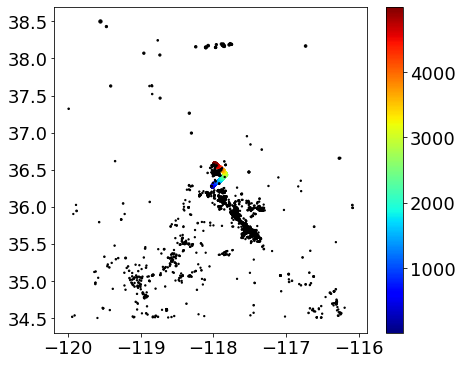

In [24]:
# TODO: add an inset with Zoom-in DAS channels
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon_new, DAS_lat_new, s=10, c=DAS_index_new, cmap='jet')
ax.scatter(eq_lon, eq_lat, s=10**(eq_mag/5), c='k')
fig.colorbar(cmp)

### Calculate the arrival time from earthquake to each das channel using 1D velocity model. If the travel time table has already been calculated, load the prepared travel time table, calculate the interpolation function to estimate the arrival times.

In [25]:
# Work out a handy travel time table to do interpolation
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees

travel_time_table_file = output_dir + '/travel_time_table_Olancha.npz'


# First look for the precalculated TTT, if not exists, get one from interpolating TauP 
if not os.path.exists(travel_time_table_file):
    model = TauPyModel(model='iasp91')

    # distance list
    distance_fit = np.linspace(0, 3, 100)
    # depth list
    depth_fit = np.arange(0, 100, 1)

    distance_grid, depth_grid = np.meshgrid(distance_fit, depth_fit)


    tavel_time_P_grid = np.zeros(distance_grid.shape)
    tavel_time_S_grid = np.zeros(distance_grid.shape)

    #for i_eq in tqdm.tqdm(range(10), desc="Calculating arrival time..."):
    for i_depth in tqdm.tqdm(range(depth_grid.shape[0]), desc="Calculating arrival time..."):   

        for i_distance in range(distance_grid.shape[1]):
            try:
                arrivals = model.get_ray_paths(depth_fit[i_depth], distance_fit[i_distance], phase_list=['p', 's'])
                tavel_time_P_grid[i_depth, i_distance] = arrivals[0].time
                tavel_time_S_grid[i_depth, i_distance] = arrivals[1].time 
            except:
                tavel_time_P_grid[i_depth, i_distance] = np.nan
                tavel_time_S_grid[i_depth, i_distance] = np.nan

    # save the calculated Travel time table
    np.savez(travel_time_table_file, distance_grid=distance_grid, depth_grid=depth_grid, 
             tavel_time_p_grid=tavel_time_P_grid, tavel_time_s_grid=tavel_time_S_grid)

    print('Travel time table calculated!')
    
    
# The TTT calculated or already exists, directly load it.
temp = np.load(travel_time_table_file)
distance_grid = temp['distance_grid']
depth_grid = temp['depth_grid']
tavel_time_p_grid = temp['tavel_time_p_grid']
tavel_time_s_grid = temp['tavel_time_s_grid']

# build the interpolation function
from scipy.interpolate import interp2d, griddata
#grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')

ii = ~np.isnan(tavel_time_p_grid) # ignore the nan
# interp_f_p = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_p_grid[ii], kind='linear')
# interp_f_s = interp2d(distance_grid[ii], depth_grid[ii], tavel_time_s_grid[ii], kind='linear')

# from one event to all channels
event_arrival_P = []
event_arrival_S = []

for i_eq in tqdm.tqdm(range(eq_num), desc="Calculating arrival time..."):   
    # estimate the arrival time of each earthquake to all channels
    if data_found_df['instrument_type'].iloc[i_eq] == 'old':
        DAS_channel_num = DAS_channel_num_old
        DAS_lat = DAS_lat_old
        DAS_lon = DAS_lon_old
    elif data_found_df['instrument_type'].iloc[i_eq] == 'new':
        DAS_channel_num = DAS_channel_num_new
        DAS_lat = DAS_lat_new
        DAS_lon = DAS_lon_new
    else:
        print('Instrument type unknown, skip...')
        continue

    distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_eq], eq_lon[i_eq])

    P_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_p_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))
    S_arrival = griddata(np.array([distance_grid[ii], depth_grid[ii]]).T, tavel_time_s_grid[ii], (distance_to_source, np.ones(distance_to_source.shape)*5))


    P_arrival = data_found_df['eq_time'].iloc[i_eq] - data_found_df['t_begin'].iloc[i_eq] + P_arrival
    S_arrival = data_found_df['eq_time'].iloc[i_eq] - data_found_df['t_begin'].iloc[i_eq] + S_arrival


    event_arrival_P.append(P_arrival)
    event_arrival_S.append(S_arrival)


np.savez(output_dir + '/DAS_estimated_arrival_time.npz', event_arrival_P=event_arrival_P, event_arrival_S=event_arrival_S)

Calculating arrival time...: 100%|██████████| 3375/3375 [21:25<00:00,  2.63it/s]
/home/yinjx/.conda/envs/das_data/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


i_file = 1150 # Before 2683 are the old data

files_abs_path = df_files.files_abs[i_file]
file_name = df_files.file_name[i_file]
t_begin = df_files.t_begin[i_file]
instrument_type = df_files.instrument_type[i_file]

DAS_dataS, info = DASutils.readFile_HDF([files_abs_path], 0.01, 20.0, taper=0.0,
                                        verbose=1, desampling=True, system="OptaSense", nChbuffer=5000)

if instrument_type == 'old': # For the old instruments, the data is phase shift, conversion is needed.
    print('conversion is needed!')
    DAS_dataS = phase_to_strain(DAS_dataS)

ntS = info['nt']
fs = info['fs']
dt = info['dt']
tAx_secS = np.linspace(0.0, (ntS-1)*dt, ntS)

# To strain rate
DAS_dataS = np.diff(DAS_dataS[:, :], axis=1)/dt
tAx_secS = tAx_secS[:-1] + dt/2
ntS = ntS - 1

In [26]:
data_found_df

,files_abs,file_name,t_begin,instrument_type,eq_id,eq_time
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old,39266879,2020-06-26T02:54:04.160000Z
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old,39266895,2020-06-26T03:28:28.370000Z
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old,39266911,2020-06-26T03:40:24.580000Z
0,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 025129Z.h5,2020-06-26T02:51:29.000000Z,old,39266903,2020-06-26T03:41:39.430000Z
1,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-26 035047Z.h5,2020-06-26T03:50:47.000000Z,old,39266919,2020-06-26T03:53:02.630000Z
...,...,...,...,...,...,...
6586,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T081002Z.h5,2021-10-13T08:10:02.000000Z,new,40068712,2021-10-13T09:01:53.940000Z
6586,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T081002Z.h5,2021-10-13T08:10:02.000000Z,new,40068720,2021-10-13T09:08:11.300000Z
6587,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T091002Z.h5,2021-10-13T09:10:02.000000Z,new,40068728,2021-10-13T09:45:42.750000Z
6588,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-13T101002Z.h5,2021-10-13T10:10:02.000000Z,new,40068736,2021-10-13T10:41:35.210000Z


### Output the windowed data for ML phase/arrival time picking

In [27]:
# Save and load event hdf5 files
import dateutil
def save_rawevent_h5(fn, data, info):
   """
   """
   info_copy = info.copy()
   with h5py.File(fn, 'w') as fid:
       fid.create_dataset('data', data=data)
       for key in info.keys():
           if isinstance(info[key], str):
               #fid['data'].attrs.modify(key, np.string_(info_copy[key]))
               fid['data'].attrs.modify(key, info_copy[key])
           else:
               fid['data'].attrs.modify(key, info_copy[key])

def load_rawevent_h5(fn):
   """
   """
   with h5py.File(fn, 'r') as fid:
       data = fid['data'][:]
       info = {}
       for key in fid['data'].attrs.keys():
           info[key] = fid['data'].attrs[key]
       info2 = {}
       if 'begin_time' in info.keys():
           info2['begTime'] = dateutil.parser.parse(info['begin_time'])
       if 'end_time' in info.keys():
           info2['endTime'] = dateutil.parser.parse(info['end_time'])
       if 'event_time' in info.keys():
           info2['time'] = dateutil.parser.parse(info['event_time'])

       info2['event_id'] = info['event_id']
       info2['nt'] = data.shape[0]
       info2['nx'] = data.shape[1]
       info2['dx'] = info['dx_m']
       info2['dt'] = info['dt_s']
   return data, info2

In [28]:
temp =np.load(output_dir + '/DAS_estimated_arrival_time.npz', allow_pickle=True)
event_arrival_P = temp['event_arrival_P'][:]
event_arrival_S = temp['event_arrival_S'][:]

In [30]:
eq_das_t0.shape, eq_time_UTCDateTime.shape

AttributeError: 'list' object has no attribute 'shape'

In [29]:
eq_mag_type

array(['ml', 'ml', 'ml', ..., 'ml', 'ml', 'ml'], dtype=object)

In [39]:
# # Test segmentation
# data_diff = np.ones((1000, 15000))
# t_begin, t_end = 30, 120
# das_time = np.linspace(10, 160, 15000)
# das_dt = 0.01

# ii_time = (das_time >= t_begin) & (das_time <= t_end)
# data_diff = data_diff[:, ii_time]
# if das_time[0] > t_begin:
#     data_diff = np.concatenate([np.zeros((data_diff.shape[0], 12000 - data_diff.shape[1])), data_diff], axis=1)
#     das_time = np.linspace(t_begin, t_end - das_dt, 12000)
# elif das_time[-1] < t_end:
#     data_diff = np.concatenate([data_diff, np.zeros((data_diff.shape[0], 12000 - data_diff.shape[1]))], axis=1)
#     das_time = np.linspace(t_begin, t_end - das_dt, 12000)
# else:
#     das_time = das_time[ii_time]   

# data_diff.shape

(1000, 9000)

In [41]:
eq_num

3375

In [27]:
data_folder_old = '/kuafu/EventData/Olancha_old/data'
data_folder_new = '/kuafu/EventData/Olancha_new/data'
figure_folder_old = '/kuafu/EventData/Olancha_old/data/figures'
figure_folder_new = '/kuafu/EventData/Olancha_new/data/figures'

eq_time_UTCDateTime = np.array(data_found_df.eq_time)
eq_das_t0 = np.array(data_found_df.t_begin)

for i_event in tqdm.tqdm(range(0, 500), desc="Extracting waveforms..."):
    try:
        data0, info = DASutils.readFile_HDF([data_found_df.files_abs.iloc[i_event]], 0.01, 40.0, taper=0.0,
                                        verbose=1, desampling=False, system="OptaSense", nChbuffer=5000)

        ntS = info['nt']
        fs = info['fs']
        das_dt = info['dt']
        das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)

        if data_found_df['instrument_type'].iloc[i_event] == 'old':
            data0 = phase_to_strain(data0) # for old generation of data, needs to be converted from phase shift to strain
            DAS_channel_num = DAS_channel_num_old
            DAS_lat = DAS_lat_old
            DAS_lon = DAS_lon_old
            DAS_index = DAS_index_old
            data_folder = data_folder_old
            figure_folder = figure_folder_old
        elif data_found_df['instrument_type'].iloc[i_event] == 'new':
            DAS_channel_num = DAS_channel_num_new
            DAS_lat = DAS_lat_new
            DAS_lon = DAS_lon_new
            DAS_index = DAS_index_new
            data_folder = data_folder_new
            figure_folder = figure_folder_new
        else:
            print('Instrument type unknown, skip...')
            continue

        
        data0 = data0[DAS_index-1, :]
        data_diff = np.diff(data0, axis=1)/das_dt * 1e6 # convert from strain rate to micro strain rate

        # time information 
        das_time = das_time[:-1] + das_dt/2

        # Taper the data
        t_begin = eq_time_UTCDateTime[i_event] - eq_das_t0[i_event] - 30
        t_end = eq_time_UTCDateTime[i_event] - eq_das_t0[i_event] + 90

        # segmented data
        ii_time = (das_time >= t_begin) & (das_time <= t_end)
        data_diff = data_diff[:, ii_time]
        if das_time[0] > t_begin:
            data_diff = np.concatenate([np.zeros((data_diff.shape[0], 12000 - data_diff.shape[1]))], data_diff, axis=1)
            das_time = np.linspace(t_begin, t_end - das_dt, 12000)
        elif das_time[-1] < t_end:
            data_diff = np.concatenate([data_diff, np.zeros((data_diff.shape[0], 12000 - data_diff.shape[1]))], axis=1)
            das_time = np.linspace(t_begin, t_end - das_dt, 12000)
        else:
            das_time = das_time[ii_time]   

        if len(das_time) > 0: # skip if the das time is not in range of event time
            event_data = data_diff.T
            event_info = {}
            event_info['event_id'] = eq_id[i_event]
            event_info['event_time'] = eq_time_UTCDateTime[i_event].isoformat()
            event_info['begin_time'] = (eq_time_UTCDateTime[i_event] - 30).isoformat() + '+00:00'
            event_info['end_time'] = (eq_time_UTCDateTime[i_event] + 90).isoformat() + '+00:00'
            event_info['latitude'] = eq_lat[i_event]
            event_info['longitude'] = eq_lon[i_event]
            event_info['depth_km'] = eq_dep[i_event]
            event_info['magnitude'] = eq_mag[i_event]
            event_info['magnitude_type'] = eq_mag_type
            event_info['source'] = 'scsn'
            event_info['dt_s'] = das_dt
            if data_found_df['instrument_type'].iloc[i_event] == 'old':
                event_info['dx_m'] = 8
                event_info['das_array'] = 'Olancha_old'
            elif data_found_df['instrument_type'].iloc[i_event] == 'new':
                event_info['dx_m'] = 10
                event_info['das_array'] = 'Olancha_new'

            save_rawevent_h5(os.path.join(data_folder, str(eq_id[i_event])+'.h5'), event_data, event_info)


            # Show data
            fig, ax1 = plt.subplots(figsize=(8, 4))
            pclip=99.5
            clipVal = np.percentile(np.absolute(data_diff), pclip)
            # Vx
            ax1.imshow(data_diff.T, 
                    extent=[0, data_diff.shape[0], das_time[-1], t_begin],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

            ax1.plot(DAS_index, event_arrival_P[i_event], '--g', zorder=10)
            ax1.plot(DAS_index, event_arrival_S[i_event], '-g', zorder=10)

            ax1.set_xlabel("Channel number")
            ax1.set_ylabel("Time [s]")
            ax1.grid()

            plt.savefig(figure_folder + f'/{eq_id[i_event]}.png')
            plt.close('all')
        else:
            continue
        
    except:
        print(f'data of event {eq_id[i_event]} not found')
        continue

Extracting waveforms...: 100%|██████████| 83/83 [2:30:06<00:00, 108.51s/it]


In [112]:
# Test loading data
data_folder = '/kuafu/EventData/Olancha_old_20200626_20210227/data'
data1, info1 = load_rawevent_h5(data_folder + '/39271783.h5')

In [113]:
info1

{'begTime': datetime.datetime(2020, 6, 29, 1, 55, 19, 10000, tzinfo=tzutc()),
 'endTime': datetime.datetime(2020, 6, 29, 1, 57, 19, 10000, tzinfo=tzutc()),
 'time': datetime.datetime(2020, 6, 29, 1, 55, 49, 10000),
 'event_id': 39271783,
 'nt': 12000,
 'nx': 6250,
 'dx': 8,
 'dt': 0.01}

In [126]:
# Save the segmented data for ML phase picking
data_folder = output_dir + '/ML_picking_data_M_3+'
if not os.path.exists(data_folder):
    os.mkdir(data_folder)

for i_event in tqdm.tqdm(range(40,eq_num), desc="Extracting waveforms..."):
    try:
        data0, info = DASutils.readFile_HDF([data_found_df.files_abs.iloc[i_event]], 0.01, 20.0, taper=0.0,
                                        verbose=1, desampling=True, system="OptaSense", nChbuffer=5000)

        ntS = info['nt']
        fs = info['fs']
        das_dt = info['dt']
        das_time = np.linspace(0.0, (ntS-1)*das_dt, ntS)

        if data_found_df['instrument_type'].iloc[i_event] == 'old':
            data0 = phase_to_strain(data0) # for old generation of data, needs to be converted from phase shift to strain
            DAS_channel_num = DAS_channel_num_old
            DAS_lat = DAS_lat_old
            DAS_lon = DAS_lon_old
            DAS_index = DAS_index_old
        elif data_found_df['instrument_type'].iloc[i_event] == 'new':
            DAS_channel_num = DAS_channel_num_new
            DAS_lat = DAS_lat_new
            DAS_lon = DAS_lon_new
            DAS_index = DAS_index_new
        else:
            print('Instrument type unknown, skip...')
            continue

        
        data0 = data0[DAS_index-1, :]
        data_diff = np.diff(data0, axis=1)/das_dt

        # time information 
        das_time = das_time[:-1] + das_dt/2

        # cut the data
        t_begin = np.min(event_arrival_P[i_event]) - 10
        t_end = np.max(event_arrival_S[i_event]) + 60

        # segmented data
        ii_time = (das_time >= t_begin) & (das_time <= t_end)
        data_diff = data_diff[:, ii_time]
        das_time = das_time[ii_time]   

        if len(das_time) > 0: # skip if the das time is not in range of event time
            # Downsample from 250 Hz to 50 Hz
            data = data_diff.T
            np.savez(data_folder + f'/{eq_id[i_event]}.npz', data=data)


            # Show data
            fig, ax1 = plt.subplots(figsize=(16,8))
            pclip=99.5
            clipVal = np.percentile(np.absolute(data_diff), pclip)
            # Vx
            ax1.imshow(data_diff.T, 
                    extent=[0, data_diff.shape[0], das_time[-1], t_begin],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

            ax1.plot(DAS_index, event_arrival_P[i_event][::-1], '--g', zorder=10)
            ax1.plot(DAS_index, event_arrival_S[i_event][::-1], '-g', zorder=10)

            ax1.set_xlabel("Channel number")
            ax1.set_ylabel("Time [s]")
            ax1.grid()

            plt.savefig(data_folder + f'/{eq_id[i_event]}.png')
            plt.close('all')
        else:
            continue
        
    except:
        print(f'data of event {eq_id[i_event]} not found')
        continue

Extracting waveforms...: 100%|██████████| 27/27 [41:29<00:00, 92.21s/it]


### Wait for ML results from Weiqiang. TODO: trying to include his code here to directly refind the time picking.

### Load the ML-picked arrival time, and check how the ML picking works

In [19]:
from scipy.interpolate import interp1d

def extrapolate_arrival_time(ml_picks, kind='linear'):
    channel = np.array(ml_picks['station_name'])
    phase_index = np.array(ml_picks['phase_index'])
    channel_all = np.arange(0, DAS_channel_num)
    if kind is None:
        phase_index_extrap = np.ones(channel_all.shape) * -1
        phase_index_extrap[channel] = phase_index
        
    else:
        interp_f = interp1d(channel, phase_index, kind=kind, fill_value='extrapolate')
        phase_index_extrap = interp_f(channel_all).astype('int')
    
    return phase_index_extrap

In [24]:
DAS_channel_num_new

4772

In [26]:
data_found_df

,files_abs,file_name,t_begin,instrument_type,eq_id,eq_time
58,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-06-29 012322Z.h5,2020-06-29T01:23:22.000000Z,old,39271783,2020-06-29T01:55:49.010000Z
147,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-02 183207Z.h5,2020-07-02T18:32:07.000000Z,old,39276943,2020-07-02T18:49:41.090000Z
385,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-14 114929Z.h5,2020-07-14T11:49:29.000000Z,old,39292639,2020-07-14T12:15:18.870000Z
502,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-19 091236Z.h5,2020-07-19T09:12:36.000000Z,old,38598026,2020-07-19T10:07:44.500000Z
538,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2020-07-20 213738Z.h5,2020-07-20T21:37:38.000000Z,old,38599882,2020-07-20T22:01:53.080000Z
...,...,...,...,...,...,...
6141,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-09-24T191002Z.h5,2021-09-24T19:10:02.000000Z,new,39818327,2021-09-24T19:28:15.220000Z
6315,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-02T011002Z.h5,2021-10-02T01:10:02.000000Z,new,40061064,2021-10-02T01:42:20.500000Z
6424,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-06T141002Z.h5,2021-10-06T14:10:02.000000Z,new,40064320,2021-10-06T14:25:27.610000Z
6458,/kuafu/DASdata/Olancha_Plexus/Olancha_Hourly/O...,Olancha-2021-10-08T001002Z.h5,2021-10-08T00:10:02.000000Z,new,40065464,2021-10-08T00:13:50.260000Z


In [31]:
data_found_df.iloc[0].instrument_type

'old'

In [27]:
ml_picks_file

[]

In [29]:
extrapolate_ml_picking = True

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling/picks_yinjx_Olancha_Plexus_100km'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling/ML_picking_data_M_3+'

das_dt = 0.02 # downsampled to 50 Hz
for i_eq, eq_id_current in enumerate(eq_id):
      
    try: 
        if data_found_df.iloc[i_eq].instrument_type == 'old':
            DAS_channel_num = DAS_channel_num_old
        elif data_found_df.iloc[i_eq].instrument_type == 'new':
            DAS_channel_num = DAS_channel_num_new
        else:
            raise NameError('need to specify the type of instruments')

            # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='linear')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='linear')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_linear.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        # Show data
        fig, ax1 = plt.subplots(figsize=(16,8))
        pclip=99.5
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1.imshow(data_diff, 
                    extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1.plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1.plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)
        
        ax1.set_title(f'Event ID: {eq_id_current}')
        ax1.set_xlabel("Channel number")
        ax1.set_ylabel("Time [s]")
        ax1.grid()

        plt.savefig(das_path + '/' + fig_name)
        plt.close('all')
        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
        
    

Event 39271783 done!
Event 39276943 done!
Event 39292639 done!
Event 38598026 done!
Event 38599882 done!
Event 38603762 done!
Event 38605954 done!
Event 39587168 done!
Event 39368535 done!
Event 38675290 done!
Event 38676562 done!
ML picking 38681266 not found, skip...
Event 38683914 done!
Event 38683930 done!
Event 38683938 done!
DAS file 38693130 not found, skip...
Event 39649656 done!
Event 39651712 done!
Event 39455887 done!
Event 39464287 done!
Event 39464303 done!
Event 39464943 done!
Event 39466791 done!
Event 39466903 done!
Event 39727992 done!
Event 39728160 done!
Event 39550567 done!
Event 39551831 done!
Event 39552143 done!
Event 39803064 done!
Event 39588623 done!
Event 39590911 done!
Event 39593831 done!
Event 39595423 done!
Event 39836272 done!
Event 39836392 done!
Event 39841832 done!
Event 39843952 done!
Event 39846664 done!
Event 39851144 done!
ML picking 39853648 not found, skip...
Event 39625767 done!
ML picking 39632735 not found, skip...
Event 39634983 done!
Event 

### Now use the ML pick time to extract maximum amplitude

In [30]:
# apply mask onto the data
def extract_maximum_amplitude(time_list, data_matrix, t1, t2):
    t1 = t1[:, np.newaxis]
    t2 = t2[:, np.newaxis]
    time_list = time_list[np.newaxis, :]
    
    # broadcast comparison
    mask_index = (time_list >= t1) & (time_list < t2)
    data_matrix_mask = data_matrix.copy()
    data_matrix_mask[~mask_index] = np.nan
    max_amplitude = np.nanmax(data_matrix_mask, axis=1)
    return max_amplitude


In [31]:
from scipy.signal import butter, filtfilt

def convert_to_strain(strain_rate, das_time, filt=True, filt_freq=0.5):
    dt = das_time[1] - das_time[0]
    strain_temp = np.cumsum(strain_rate * das_time, axis=1)
    if filt:
        aa, bb = butter(2, filt_freq * 2 * dt, btype='high')
        strain_temp = filtfilt(aa, bb, strain_temp, axis=1)
        
    return strain_temp


In [33]:
extrapolate_ml_picking = False
# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling/picks_yinjx_Olancha_Plexus_100km'
# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling/ML_picking_data_M_3+'

from obspy.geodetics import locations2degrees

# extract the maximum amplitude
peak_ampliutde_P_all = np.array([])
peak_ampliutde_S_all = np.array([])
peak_strain_P_all = np.array([]) # strain
peak_strain_S_all = np.array([]) # strain
distance_all = np.array([])
magnitude_all = np.array([])
event_id_all = np.array([])
channel_id_all = np.array([])

das_dt = 0.02 # downsampled to 50 Hz

for i_eq, eq_id_current in enumerate(eq_id):
      
    try: 
        if data_found_df['instrument_type'].iloc[i_eq] == 'old':
            DAS_channel_num = DAS_channel_num_old
            DAS_lat = DAS_lat_old
            DAS_lon = DAS_lon_old
            DAS_index = DAS_index_old
            to_nano_factor = 1e9
        elif data_found_df['instrument_type'].iloc[i_eq] == 'new':
            DAS_channel_num = DAS_channel_num_new
            DAS_lat = DAS_lat_new
            DAS_lon = DAS_lon_new
            DAS_index = DAS_index_new
            to_nano_factor = 1e3 # New data is in micro strain, so only 1e3
        else:
            print('Instrument type unknown, skip...')
            continue

            # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]

        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        end_time = np.ones(event_arrival_S_ml.shape) * das_time[-1]

        data_diff = data_diff.T
        # Extract the maximum given the P and S arrival time
        max_P_amplitude = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_amplitude = extract_maximum_amplitude(das_time, abs(data_diff), 
                                                    event_arrival_S_ml, end_time)

        # Also extract strain maximum
        strain = convert_to_strain(data_diff, das_time)
        # Extract the maximum strain given the P and S arrival time
        max_P_strain = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_P_ml, event_arrival_S_ml)
        max_S_strain = extract_maximum_amplitude(das_time, abs(strain), 
                                                    event_arrival_S_ml, end_time)

        # strain to nanostrain
        max_P_amplitude = max_P_amplitude * to_nano_factor
        max_S_amplitude = max_S_amplitude * to_nano_factor
        max_P_strain = max_P_strain * to_nano_factor
        max_S_strain = max_S_strain * to_nano_factor


        # Distance from each channel to the source
        distance_to_source = locations2degrees(DAS_lat, DAS_lon, eq_lat[i_eq], eq_lon[i_eq])

        # Magnitude of each earhtquake
        
        magnitude_all = np.concatenate((magnitude_all, np.ones(DAS_lat.shape) * eq_mag[i_eq]), axis=0)
        # A simple event label
        
        event_id_all = np.concatenate((event_id_all, (np.ones(DAS_lat.shape) * eq_id_current).astype('int')), axis=0)
        # Channel id
        
        channel_id_all = np.concatenate((channel_id_all, DAS_index), axis=0)


        
        peak_ampliutde_P_all = np.concatenate((peak_ampliutde_P_all, max_P_amplitude), axis=0)
        
        peak_ampliutde_S_all = np.concatenate((peak_ampliutde_S_all, max_S_amplitude), axis=0)
        
        peak_strain_P_all = np.concatenate((peak_strain_P_all, max_P_strain), axis=0)
        
        peak_strain_S_all = np.concatenate((peak_strain_S_all, max_S_strain), axis=0)
        
        distance_all = np.concatenate((distance_all, distance_to_source), axis=0)
        print('=' * 10 + f'Event {eq_id_current} done!' + '=' * 10)
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
    

/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39271783 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39276943 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39292639 done!==========
DAS file 38598026 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38599882 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38603762 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38605954 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39587168 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39368535 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38675290 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38676562 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38681266 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38683914 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38683930 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38683938 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 38693130 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39649656 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39651712 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39455887 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39464287 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39464303 done!==========
DAS file 39464943 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39466791 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39466903 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39727992 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39728160 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39550567 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39551831 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39552143 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39803064 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39588623 done!==========
DAS file 39590911 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39593831 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39595423 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39836272 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39836392 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39841832 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39843952 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39846664 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39851144 done!==========
ML picking 39853648 not found, skip...
DAS file 39625767 not found, skip...
DAS file 39632735 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39634983 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 37474293 done!==========
DAS file 37474213 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39659271 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 37474917 done!==========
ML picking 39906312 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39718407 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39725271 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39727759 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39730287 done!==========
DAS file 37477941 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39735647 done!==========
DAS file 39744871 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39748247 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39753207 done!==========
ML picking 40024128 not found, skip...
ML picking 40027904 not found, skip...
ML picking 40034008 not found, skip...


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39806479 done!==========


/tmp/ipykernel_29740/3094523104.py:11: RuntimeWarning: All-NaN slice encountered
  max_amplitude = np.nanmax(data_matrix_mask, axis=1)


==========Event 39818327 done!==========
ML picking 40061064 not found, skip...
ML picking 40064320 not found, skip...
ML picking 40065464 not found, skip...
ML picking 40068112 not found, skip...


### Flatten all the measured results. Output all the results.

In [34]:
peak_ampliutde_P_all_flatten = np.array(peak_ampliutde_P_all).flatten()
peak_ampliutde_S_all_flatten = np.array(peak_ampliutde_S_all).flatten()
peak_strain_P_all_flatten = np.array(peak_strain_P_all).flatten()
peak_strain_S_all_flatten = np.array(peak_strain_S_all).flatten()
distance_all_flatten = np.array(distance_all).flatten()
distance_all_km_flatten = distance_all_flatten * 113
magnitude_all_flatten = np.array(magnitude_all).flatten()
event_id_all_flatten = np.array(event_id_all).flatten()
channel_id_all_flatten = np.array(channel_id_all).flatten()

In [35]:
output_file_name = output_dir + '/peak_amplitude_M3+.csv'

all_combined = np.array([event_id_all_flatten, 
                         magnitude_all_flatten, 
                         distance_all_km_flatten, 
                         peak_ampliutde_P_all_flatten, 
                         peak_ampliutde_S_all_flatten,
                         peak_strain_P_all_flatten,
                         peak_strain_S_all_flatten,
                         channel_id_all_flatten]).T

peak_amplitude_df = pd.DataFrame(data=all_combined, 
                                 columns=['event_id', 'magnitude', 'distance_in_km', 'peak_P', 'peak_S','peak_P_strain', 'peak_S_strain', 'channel_id'])

peak_amplitude_df = peak_amplitude_df.dropna()
# Write the results to a csv file
peak_amplitude_df.to_csv(output_file_name, index=False)

In [42]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/home/yinjx/kuafu/Olancha_Plexus_100km/Olancha_scaling'

peak_amplitude_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(peak_amplitude_file_name)

In [43]:
peak_amplitude_df

,event_id,magnitude,distance_in_km,peak_P,peak_S,peak_P_strain,peak_S_strain,channel_id
0,39271783.0,3.55,23.485964,3744.980957,12816.092773,91878.805371,515246.328011,120.0
1,39271783.0,3.55,23.480638,2992.226074,11787.444336,67933.155325,430414.416537,121.0
2,39271783.0,3.55,23.475215,2190.245117,9127.552734,46024.941669,350043.957959,122.0
3,39271783.0,3.55,23.469793,2795.888916,10073.426758,70528.147433,487849.339371,123.0
4,39271783.0,3.55,23.464468,2594.456055,12559.029297,63973.704700,440275.957340,124.0
...,...,...,...,...,...,...,...,...
78975,39818327.0,3.44,113.519221,73.807129,143.944672,6188.535680,25056.175002,4278.0
78976,39818327.0,3.44,113.528745,90.643761,151.304535,6271.362060,18976.529330,4279.0
78977,39818327.0,3.44,113.838120,75.141525,111.712700,4607.858315,13320.621708,4333.0
78978,39818327.0,3.44,113.873547,101.340126,153.080154,6009.180547,17860.066574,4334.0


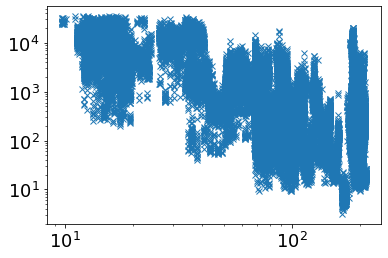

In [44]:
plt.loglog(peak_amplitude_df.distance_in_km, peak_amplitude_df.peak_P,'x')

In [112]:
def filter_das_data(strain_rate, das_time, filt_freq=0.5):
    dt = das_time[1] - das_time[0]
    aa, bb = butter(2, filt_freq * 2 * dt, btype='high')
    strain_rate = filtfilt(aa, bb, strain_rate, axis=1)    
    return strain_rate

In [18]:
extrapolate_ml_picking = False

# path of the ML picking 
ml_pick_dir = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling_filter/picks_yinjx_Olancha_Plexus_100km'

# Check the segmented 50Hz data
das_path = '/kuafu/yinjx/Olancha_Plexus_100km/Olancha_scaling_filter/ML_picking_data_M_3+'

das_dt = 0.02 # downsampled to 50 Hz
eq_id0 = [37474917]
for i_eq, eq_id_current in enumerate(eq_id0):
      
    try: 
        if data_found_df.iloc[i_eq].instrument_type == 'old':
            DAS_channel_num = DAS_channel_num_old
        elif data_found_df.iloc[i_eq].instrument_type == 'new':
            DAS_channel_num = DAS_channel_num_new
        else:
            raise NameError('need to specify the type of instruments')

            # look for the corresponding ML picks
        ml_picks_file = glob.glob(ml_pick_dir + f'/*{eq_id_current}.csv')
        ml_picks = pd.read_csv(ml_picks_file[0])

        # extract the picked information
        ml_picks_p = ml_picks[ml_picks['phase_type'] == 'p']
        ml_picks_s = ml_picks[ml_picks['phase_type'] == 's']

        # remove some duplicated picks, only keep those with higher probability
        ml_picks_p = ml_picks_p.drop_duplicates(subset=['station_name'], keep='first')
        ml_picks_s = ml_picks_s.drop_duplicates(subset=['station_name'], keep='first')
        
        if extrapolate_ml_picking:
            # extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind='nearest')
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind='nearest')
            channel_of_picks_P = np.arange(DAS_channel_num)
            channel_of_picks_S = np.arange(DAS_channel_num)
            fig_name = f'{eq_id_current}_ml_extrap_nearest.png'
        else:
            # not extrapolate the index in case the ML picking is imcomplete
            event_arrival_P_ml_index = extrapolate_arrival_time(ml_picks_p, kind=None)
            event_arrival_S_ml_index = extrapolate_arrival_time(ml_picks_s, kind=None)
            channel_of_picks_P = ml_picks_p['station_name']
            channel_of_picks_S = ml_picks_s['station_name']
            fig_name = f'{eq_id_current}_ml.png'
        
    except:
        print(f'ML picking {eq_id_current} not found, skip...')
        continue
        
    try:      
        # look for the corresponding data file
        file_name = glob.glob(das_path + f'/*{eq_id_current}.npz')
        temp = np.load(file_name[0])
        data_diff = temp[temp.files[0]]
        
        # time information 
        das_time = np.arange(data_diff.shape[0]) * das_dt

        # get the ML pick time
        event_arrival_P_ml = das_time[event_arrival_P_ml_index.astype('int')]
        event_arrival_S_ml = das_time[event_arrival_S_ml_index.astype('int')]

        # Slight modify only for plotting purpose
        event_arrival_P_ml[event_arrival_P_ml == das_time[-1]] = np.nan
        event_arrival_S_ml[event_arrival_S_ml == das_time[-1]] = np.nan

        data_diff2 = filter_das_data(data_diff, das_time, filt_freq=0.1)

        # Show data
        fig, ax1 = plt.subplots(1,2, figsize=(16,8))
        pclip=99.5
        clipVal = np.percentile(np.absolute(data_diff), pclip)
        # Vx
        ax1[0].imshow(data_diff, 
                    extent=[0, data_diff.shape[1], das_time[-1], das_time[0]],
                    aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1[0].plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1[0].plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)
        
        ax1[0].set_title(f'Event ID: {eq_id_current}')
        ax1[0].set_xlabel("Channel number")
        ax1[0].set_ylabel("Time [s]")
        ax1[0].grid()

        clipVal = np.percentile(np.absolute(data_diff2), pclip)
        ax1[1].imshow(data_diff2, 
            extent=[0, data_diff2.shape[1], das_time[-1], das_time[0]],
            aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

        ax1[1].plot(event_arrival_P_ml, '--k', linewidth=2, zorder=10)
        ax1[1].plot(event_arrival_S_ml, '-k', linewidth=2, zorder=10)
        
        ax1[1].set_title(f'Event ID: {eq_id_current}')
        ax1[1].set_xlabel("Channel number")
        ax1[1].set_ylabel("Time [s]")
        ax1[1].grid()

        print(f'Event {eq_id_current} done!')
        
    except:
        print(f'DAS file {eq_id_current} not found, skip...')
        continue
        
        
    

NameError: name 'extrapolate_arrival_time' is not defined

In [102]:
data_diff2.shape

(5118, 4772)

In [95]:
data_diff

array([[ 0.08608326,  0.07319003,  0.03050268, ..., -0.00021569,
        -0.00374019, -0.00171438],
       [-0.02485812, -0.05957931, -0.07618517, ...,  0.00030883,
        -0.00723675, -0.00237823],
       [-0.0608027 , -0.04519671, -0.00699088, ...,  0.00732802,
        -0.00316128,  0.00068918],
       ..., 
       [-0.00773519,  0.03963113,  0.03783405, ...,  0.00217855,
        -0.00986382, -0.02079234],
       [-0.02572164, -0.01088232, -0.0686124 , ..., -0.01292489,
        -0.02678409, -0.02912208],
       [ 0.00328049, -0.01254976, -0.03070086, ...,  0.00801422,
         0.00044405, -0.00832155]], dtype=float32)

In [37]:
ml_picks

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
0,38229138.npz,1,512,0.850,p,1970-01-01T00:00:05.120,0.01
1,38229138.npz,2,512,0.903,p,1970-01-01T00:00:05.120,0.01
2,38229138.npz,3,512,0.933,p,1970-01-01T00:00:05.120,0.01
3,38229138.npz,4,512,0.956,p,1970-01-01T00:00:05.120,0.01
4,38229138.npz,5,512,0.969,p,1970-01-01T00:00:05.120,0.01
...,...,...,...,...,...,...,...
1375,38229138.npz,1141,734,0.884,s,1970-01-01T00:00:07.340,0.01
1376,38229138.npz,1142,734,0.878,s,1970-01-01T00:00:07.340,0.01
1377,38229138.npz,1143,733,0.864,s,1970-01-01T00:00:07.330,0.01
1378,38229138.npz,1144,733,0.831,s,1970-01-01T00:00:07.330,0.01


In [30]:
ml_picks_p['station_name']

0          1
1          2
2          3
3          4
4          5
        ... 
1150    1144
1151    1145
1152    1146
1153    1147
1154    1148
Name: station_name, Length: 1155, dtype: int64

In [44]:
ml_picks_s[ml_picks_s.duplicated(subset=['station_name'], keep=False)]

,file_name,station_name,phase_index,phase_score,phase_type,phase_time,dt
1862,38544311.npz,572,1925,0.888,s,1970-01-01T00:00:19.250,0.01
1863,38544311.npz,572,984,0.815,s,1970-01-01T00:00:09.840,0.01
1864,38544311.npz,573,1927,0.877,s,1970-01-01T00:00:19.270,0.01
1865,38544311.npz,573,985,0.824,s,1970-01-01T00:00:09.850,0.01
1866,38544311.npz,574,1927,0.878,s,1970-01-01T00:00:19.270,0.01
...,...,...,...,...,...,...,...
2053,38544311.npz,708,1000,0.829,s,1970-01-01T00:00:10.000,0.01
2054,38544311.npz,709,1942,0.868,s,1970-01-01T00:00:19.420,0.01
2055,38544311.npz,709,1000,0.808,s,1970-01-01T00:00:10.000,0.01
2107,38544311.npz,830,1015,0.835,s,1970-01-01T00:00:10.150,0.01


In [38]:
a = np.ones(3)